In [1]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.stats import gmean
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook as tqdm
from toolkit.postprocessing import BlendingOptimizer

sys.path.append('../')
from src.utils import read_oof_predictions, calculate_rank

PROJECT_DIR = 'PATH/TO/YOUR/EXPERIMENT'
PROJECT_DIR = '/mnt/ml-team/minerva/open-solutions/home-credit'
FIRST_LEVEL_PREDICTIONS_DIR = os.path.join(PROJECT_DIR,'files','out_of_fold_predictions','first_level')
SECOND_LEVEL_PREDICTIONS_DIR = os.path.join(PROJECT_DIR,'files','out_of_fold_predictions','second_level')
MISC_PREDICTIONS_DIR = os.path.join(PROJECT_DIR,'files','out_of_fold_predictions','misc')
TRAIN_FILEPATH = os.path.join(PROJECT_DIR,'files','unzipped_data','application_train.csv')
OUTPUT_DIR = 'PATH/TO/YOUR/OUTPUT'
OUTPUT_DIR = '/mnt/ml-team/homes/jakub.czakon/'

In [2]:
train_oof, test_oof = read_oof_predictions(FIRST_LEVEL_PREDICTIONS_DIR, TRAIN_FILEPATH, 'SK_ID_CURR','TARGET')
train_oof_second, test_oof_second = read_oof_predictions(SECOND_LEVEL_PREDICTIONS_DIR, TRAIN_FILEPATH, 'SK_ID_CURR','TARGET')
train_oof_misc, test_oof_misc = read_oof_predictions(MISC_PREDICTIONS_DIR, TRAIN_FILEPATH, 'SK_ID_CURR','TARGET')

In [3]:
train_oof.head()

,SK_ID_CURR,fold_id,hc11281_cv_6057,hc11288_cv_656,hc_10056_cv_7906_lb_797,hc_10114_cv_7909_lb_796,hc_10118_cv_7964_lb_802,hc_10215_cv_7648_lb_763,hc_10489_cv_7958,hc_10490_cv_7959,...,hc_3280_cv_786_lb_789,hc_3309_cv_7876_lb_794,hc_3524_cv_7902_lb_800,hc_3551_cv_7905_lb_801,hc_5425_cv_7937_lb_802,hc_6922_cv_7939_lb_803,hc_7384_cv_7949_lb_804,hc_7460_cv_795_lb_802,hc_9621_cv_7953_lb_802,TARGET
0,100002,0,0.078237,0.043538,0.251880,0.265587,0.333749,0.329470,0.260009,0.326841,...,0.307336,0.280868,0.325579,0.267250,0.293824,0.276275,0.321653,0.254900,0.277028,1
1,100009,0,0.032102,0.025295,0.005737,0.007261,0.005291,0.019278,0.003801,0.005143,...,0.006926,0.006497,0.005586,0.009310,0.005060,0.005706,0.006335,0.004931,0.005600,0
2,100011,0,0.083602,0.060036,0.042490,0.037069,0.069900,0.118045,0.050848,0.054304,...,0.052318,0.067975,0.049415,0.052272,0.057841,0.066099,0.066478,0.061194,0.047817,0
3,100014,0,0.057971,0.114427,0.038437,0.037902,0.061560,0.158096,0.049770,0.050426,...,0.038632,0.033325,0.050094,0.030622,0.044599,0.037532,0.042550,0.051356,0.049448,0
4,100017,0,0.045703,0.026271,0.010557,0.011709,0.015666,0.040064,0.013338,0.015794,...,0.027470,0.021329,0.025450,0.024129,0.019065,0.019293,0.017553,0.014585,0.016047,0


# Predictions
## Correlations

TARGET                     1.000000
hc_11405_cv_7964_lb_802    0.348068
hc_10118_cv_7964_lb_802    0.347993
hc_10490_cv_7959           0.347620
hc_10489_cv_7958           0.347481
hc_9621_cv_7953_lb_802     0.346792
hc_7460_cv_795_lb_802      0.346242
hc_7384_cv_7949_lb_804     0.346131
hc_6922_cv_7939_lb_803     0.344693
hc_5425_cv_7937_lb_802     0.344248
hc_10114_cv_7909_lb_796    0.340552
hc_3551_cv_7905_lb_801     0.339059
hc_10056_cv_7906_lb_797    0.338698
hc_3524_cv_7902_lb_800     0.338211
hc_3309_cv_7876_lb_794     0.333606
hc_3224_cv_786_lb_787      0.332822
hc_2396_cv_786_lb_790      0.332571
hc_3280_cv_786_lb_789      0.330479
hc_11291_cv_7651           0.301701
hc_11520_cv_763_lb_756     0.297675
hc_10215_cv_7648_lb_763    0.290784
hc_10757_cv_7486_lb_747    0.247710
hc_11249_cv_6621_lb_664    0.176920
hc11288_cv_656             0.171447
hc_11240_cv_652            0.160011
hc_11231_cv_6455_lb_642    0.148578
hc_10754_cv_6451_lb_648    0.122145
hc11281_cv_6057            0

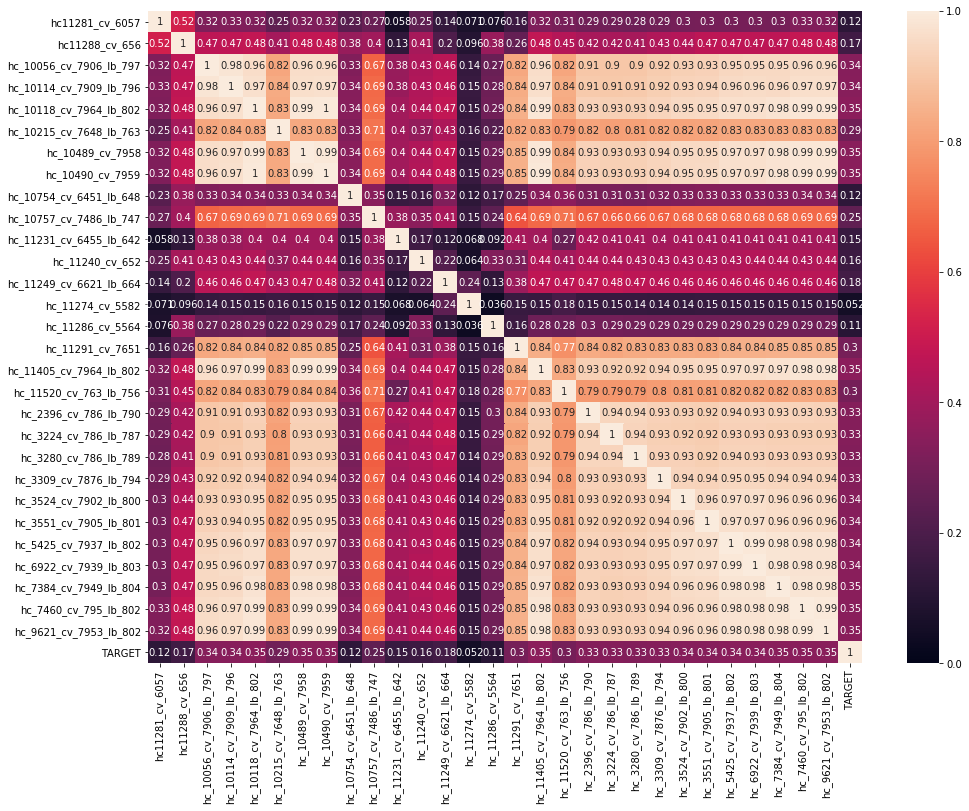

In [4]:
X_cols = [col for col in train_oof.columns if '_cv_' in col]
X, y = train_oof[X_cols], train_oof['TARGET']
X_corr = pd.concat([X,y], axis=1).corr()
display(X_corr.sort_values('TARGET', ascending=False)['TARGET'])
plt.figure(figsize=(16,12))
sns.heatmap(X_corr, xticklabels=X_corr.columns, yticklabels=X_corr.columns, 
            annot=True,vmin=0.0,vmax=1.0)
plt.show()

# Ranks 

In [5]:
def transform_to_ranks(train_oof, test_oof):
    X_cols = [col for col in train_oof.columns if '_cv_' in col]
    train_oof_rank, test_oof_rank = [],[]
    for fold_id in range(5):
        train_oof_fold = train_oof[train_oof['fold_id']==fold_id]
        test_oof_fold = test_oof[test_oof['fold_id']==fold_id]
        for col in X_cols:
            train_oof_fold[col] = calculate_rank(train_oof_fold[col])
            test_oof_fold[col] = calculate_rank(test_oof_fold[col])
        train_oof_rank.append(train_oof_fold)
        test_oof_rank.append(test_oof_fold)

    train_oof_rank = pd.concat(train_oof_rank, axis=0)
    test_oof_rank = pd.concat(test_oof_rank, axis=0)
    return train_oof_rank, test_oof_rank

train_oof_rank, test_oof_rank = transform_to_ranks(train_oof, test_oof)

/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


TARGET                     1.000000
hc_11405_cv_7964_lb_802    0.279771
hc_10118_cv_7964_lb_802    0.279765
hc_10490_cv_7959           0.279323
hc_10489_cv_7958           0.279220
hc_9621_cv_7953_lb_802     0.278739
hc_7460_cv_795_lb_802      0.278504
hc_7384_cv_7949_lb_804     0.278313
hc_6922_cv_7939_lb_803     0.277430
hc_5425_cv_7937_lb_802     0.277193
hc_10114_cv_7909_lb_796    0.274528
hc_10056_cv_7906_lb_797    0.274275
hc_3551_cv_7905_lb_801     0.274152
hc_3524_cv_7902_lb_800     0.273831
hc_3309_cv_7876_lb_794     0.271442
hc_2396_cv_786_lb_790      0.270090
hc_3224_cv_786_lb_787      0.269846
hc_3280_cv_786_lb_789      0.268444
hc_11291_cv_7651           0.250211
hc_10215_cv_7648_lb_763    0.249884
hc_11520_cv_763_lb_756     0.248268
hc_10757_cv_7486_lb_747    0.234643
hc_11249_cv_6621_lb_664    0.153249
hc11288_cv_656             0.147326
hc_11240_cv_652            0.143634
hc_11231_cv_6455_lb_642    0.137371
hc_10754_cv_6451_lb_648    0.136986
hc11281_cv_6057            0

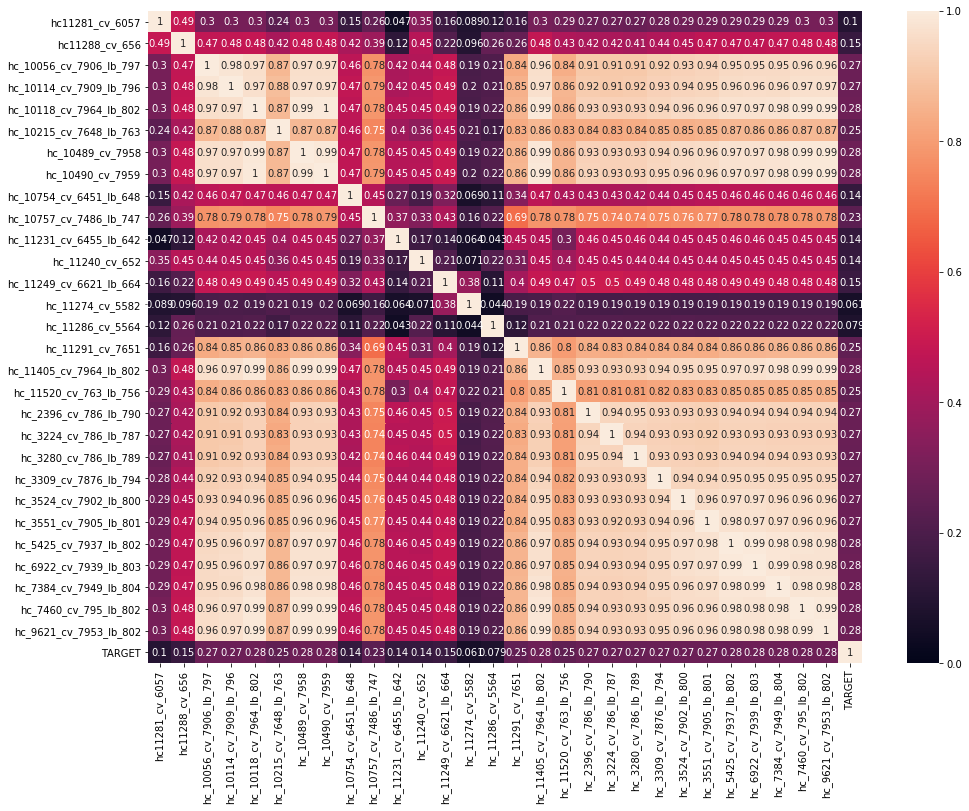

In [6]:
X_cols = [col for col in train_oof_rank.columns if '_cv_' in col]
X, y = train_oof_rank[X_cols], train_oof_rank['TARGET']
X_corr = pd.concat([X,y], axis=1).corr()
display(X_corr.sort_values('TARGET', ascending=False)['TARGET'])
plt.figure(figsize=(16,12))
sns.heatmap(X_corr, xticklabels=X_corr.columns, yticklabels=X_corr.columns, 
            annot=True,vmin=0.0,vmax=1.0)
plt.show()

# Weights optimization

In [7]:
blender = BlendingOptimizer(metric=roc_auc_score, maximize=True)

blender.fit(X=X.transpose(), y=y.tolist(),
            step_size = 0.25, init_weights = None, warm_start = False)

In [9]:
X_cols = [col for col in train_oof_rank.columns if '_cv_' in col]
y_pred = blender.transform(train_oof_rank[X_cols].transpose())['y_pred']
roc_auc_score(y, y_pred)

0.7976674433549795

In [10]:
y_pred_test = blender.transform(test_oof_rank[X_cols].transpose())['y_pred']

def create_submission(y_pred_test, test):
    test_predictions = test[['SK_ID_CURR','fold_id']]
    test_predictions['TARGET'] = y_pred_test
    submission = []
    for fold_id, fold_df in test_predictions.groupby('fold_id'):
        fold_df['TARGET'] = calculate_rank(fold_df['TARGET'])
        submission.append(fold_df)
    submission = pd.concat(submission, axis=0)
    submission = submission.groupby('SK_ID_CURR')['TARGET'].apply(np.mean).reset_index()
    return submission

submission_first = create_submission(y_pred_test, test_oof_rank)

/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
submission_first.head()

,SK_ID_CURR,TARGET
0,100001,0.421984
1,100005,0.827051
2,100013,0.473501
3,100028,0.479791
4,100038,0.906792


# Second level models

In [12]:
train_oof_second_rank, test_oof_second_rank = transform_to_ranks(train_oof_second, 
                                                                 test_oof_second)

/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
X_cols = [col for col in train_oof_second_rank.columns if '_cv_' in col]
X, y = train_oof_second_rank[X_cols], train_oof_second_rank['TARGET']

In [14]:
X.head()

,hc_10738_cv_7967_lb_803,hc_10739_cv_7967_lb_803,hc_11493_cv_7972_lb_802
0,0.963238,0.968783,0.954832
1,0.037079,0.037851,0.044883
2,0.602627,0.586157,0.604782
3,0.489757,0.508113,0.561703
4,0.204442,0.178460,0.126081


In [15]:
blender_second = BlendingOptimizer(metric=roc_auc_score, maximize=True)

blender_second.fit(X=X.transpose(), y=y.tolist(),
            step_size = 0.05, init_weights = None, warm_start = False)

In [16]:
y_pred = blender_second.transform(train_oof_second_rank[X_cols].transpose())['y_pred']
roc_auc_score(y, y_pred)

0.7972671402605074

In [17]:
y_pred_test_second = blender_second.transform(test_oof_second_rank[X_cols].transpose())['y_pred']

submission_second = create_submission(y_pred_test_second, test_oof_second_rank)

/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
submission_second.head()

,SK_ID_CURR,TARGET
0,100001,0.415546
1,100005,0.833419
2,100013,0.461651
3,100028,0.469053
4,100038,0.905832


# Misc Models

In [19]:
train_oof_misc_rank, test_oof_misc_rank = transform_to_ranks(train_oof_misc, test_oof_misc)

/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
test_oof_misc_rank.head()

,SK_ID_CURR,fold_id,hc_11095_cv_7957_lb_805,hc_11820_cv_7976_lb_802
0,100001,0,0.435655,0.403364
1,100005,0,0.886265,0.800021
2,100013,0,0.430547,0.437501
3,100028,0,0.432557,0.449072
4,100038,0,0.860950,0.893097


In [21]:
submission_misc = create_submission(test_oof_misc_rank['hc_11095_cv_7957_lb_805'], test_oof_misc_rank)

/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/mnt/ml-team/homes/milosz.michta/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
submission_misc.head()

,SK_ID_CURR,TARGET
0,100001,0.445822
1,100005,0.836508
2,100013,0.407828
3,100028,0.518326
4,100038,0.873423


# Average First+Second+Misc

In [23]:
submission = submission_first.copy()

sub_first = submission_first['TARGET']
sub_second = submission_second['TARGET']
sub_misc = submission_misc['TARGET']

submission['TARGET'] = (1.0 * sub_first + 1.0 * sub_second + 1.0 * sub_misc)/3.

In [24]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.427784
1,100005,0.832326
2,100013,0.447660
3,100028,0.489057
4,100038,0.895349


# Submission

In [25]:
submission.to_csv(os.path.join(OUTPUT_DIR,'submission.csv'),index=None)

PermissionError: [Errno 13] Permission denied: '/mnt/ml-team/homes/jakub.czakon/submission.csv'